In [1]:
from typing import Union
import pdb
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
import numpy as np
import control
import pdb
import jax
from jax import lax
import lineax
from helpers_impl import generate_system,  NeuralODEPlant, get_gpu_memory, generate_system_canon, generate_system_canon2
from tqdm import tqdm
import gc
from IPython.display import clear_output
from jax.flatten_util import ravel_pytree
from diffrax import diffeqsolve, Tsit5, ODETerm, ReversibleHeun, Heun
jax.config.update("jax_enable_x64", False)

In [81]:
data_size=1
A,B=generate_system_canon(data_size)

system is controllable
system is observable


In [87]:

#initialize the dynamical system
#A=np.array([[1,0],[1,0]])
#B=np.array([[1,0],[0,0]])
#x00=np.array([[1,0.5]])

seed=5679
key = jr.PRNGKey(seed)
x00=np.array(jr.normal(key, shape=(1, data_size)))
x00=x00/np.sqrt(np.sum(x00**2))

%store  A
%store   B
%store  x00
print(A)
print(B)
print(x00)
batch_size=1  

t_size=32
t0 = 0
t1 = 1
ts = jnp.linspace(t0, t1, t_size)
#tss = jnp.expand_dims(ts, axis=0)

#initialize the ODE
seed=5679

hidden_size=data_size
noise_size=hidden_size+1
width_size=10*data_size
depth=10

key = jr.PRNGKey(seed)

generator = NeuralODEPlant(
    data_size,
    hidden_size,
    width_size,
    depth,
    A,
    B,
    key=key,
)


#learning rate
learning_rate=0.000122/4

#adam optimizer
b1=0.9
b2=0.999
eps=1e-08
optim = optax.adam(learning_rate, b1=b1, b2=b2, eps=0, eps_root=eps)

opt_state = optim.init(eqx.filter(generator, eqx.is_inexact_array))
R=0.000001


#initial conditions 
y0=jnp.append(x00, jnp.zeros((1,1)))


args=(A,B)
#common denominator term
@jax.jit
def smoothed_inverse_grad(grad, eps=1e-05):
    return 1.0 / jnp.sqrt(grad + eps)

#for cost and its gradient evaluation
@eqx.filter_value_and_grad  
def loss(model):
   
    pred_y = model(ts,  y0, args)

    los_energy = jnp.sum(pred_y[-1,0:hidden_size]**2)#+R*(pred_y[-1,-1])

    return los_energy

#for energy and its gradient evaluation
@eqx.filter_jit 
def loss_kin(model):
   
    pred_y = model(ts,  y0, args)
 
    kin_energy=  (pred_y[-1,-1])
 
    return kin_energy



    
@eqx.filter_jit
def make_step(model, batch_size, tsss,  opt_state, y0, counter, optim):


    
    #evaluate loss, energy and gradients
    value, grads = loss(model)
    value1= loss_kin(model)

    #update the control network
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    counter+=1
    return model, opt_state, grads, value, value1,  counter

#compute the first values of cost and energy for ema 
tot_iter=100000
losses, grads = loss(generator)
kin = loss_kin(generator)
arr, static = eqx.partition(generator, eqx.is_inexact_array)
params, unravel_fn = ravel_pytree(arr)
flat_grads, _ = ravel_pytree(eqx.filter(grads, eqx.is_inexact_array))
ema_grad =  flat_grads
ema_sqr_grad = jnp.square(flat_grads)

Stored 'A' (ndarray)
Stored 'B' (ndarray)
Stored 'x00' (ndarray)
[[0.56790907]]
[[1.]]
[[1.]]


In [89]:
saved_global_loss=[]
saved_global_kin=[]
saved_global_emaloss=[]
saved_global_emakin=[]
saved_global_orparam=[]


for glob in tqdm(range(0,20)):
    seed=5679
    key = jr.PRNGKey(seed)
    strategy="vector"
    
    generator = NeuralODEPlant(
    data_size,
    hidden_size,
    width_size,
    depth,
    A,
    B,
    key=key,
    )

    
    tot_iter=5000

    learning_rate=0.00003*(2**(glob/2))
    #learning_rate= 0.0001
    #adam optimizer
    b1=0.9
    b2=0.999
    eps=1e-08
    optim = optax.adam(learning_rate, b1=b1, b2=b2, eps=0, eps_root=eps)
    
    opt_state = optim.init(eqx.filter(generator, eqx.is_inexact_array))
    
    
    #save costs and energy
    saved_loss=[]
    saved_kin=[]
    #save directional derivatives
    saved_product1=[]
    saved_product2=[]
    saved_ema_loss=[]
    saved_ema_kin=[]
    saved_orparam=[]

    alpha=0.995
    
    counter=jnp.int32(0)
    
    
    score=10000000
    epochs=[]
    ema_loss=0
    ema_kin=0
    for k in tqdm(range(0,tot_iter)):
       

        #run optimization steps, evaluate the cost and energy, directional derivatives
        generator, opt_state, grads, losses, kin,  counter= make_step(generator, batch_size, ts,  opt_state, y0, counter, optim)
        
        if k==0:
            ema_loss=losses
            ema_kin = kin
        else:
            ema_loss=ema_loss*alpha+losses*(1-alpha)
            ema_kin=ema_kin*alpha+kin*(1-alpha)
            
        if ema_loss<score:
            score=ema_loss
    
        print("ema loss")
        print(ema_loss)
        print("kin")
        print(kin)
        print("order param")
  
        saved_loss.append(jax.device_get(losses))
        saved_kin.append(jax.device_get(kin))
        saved_ema_loss.append(jax.device_get(ema_loss))
        saved_ema_kin.append(jax.device_get(ema_kin))
     
    
        if k%500==0:
            gc.collect()
            clear_output(wait=True)
            
        if jnp.linalg.norm(ema_loss)<(1e-06):
            break
        del grads, losses, kin
        
    saved_global_loss.append(saved_loss)
    saved_global_kin.append(saved_kin)
    saved_global_emaloss.append(saved_ema_loss)
    saved_global_emakin.append(saved_ema_kin)
   



 50%|█████     | 2511/5000 [00:47<01:22, 30.27it/s]

ema loss
8.498687e-06
kin
1.7180381
order param
ema loss
8.456193e-06
kin
1.7180381
order param
ema loss
8.413913e-06
kin
1.7180341
order param
ema loss
8.371843e-06
kin
1.7180343
order param
ema loss
8.329984e-06
kin
1.7180381
order param
ema loss
8.288333e-06
kin
1.7180381
order param
ema loss
8.246891e-06
kin
1.7180345
order param
ema loss
8.205657e-06
kin
1.7180341
order param
ema loss
8.1646285e-06
kin
1.7180377
order param
ema loss
8.123806e-06
kin
1.718038
order param
ema loss
8.083187e-06
kin
1.7180345
order param
ema loss
8.042771e-06
kin
1.7180347
order param



 50%|█████     | 2523/5000 [00:47<01:03, 38.95it/s]

ema loss
8.002557e-06
kin
1.7180377
order param
ema loss
7.962544e-06
kin
1.7180372
order param
ema loss
7.922731e-06
kin
1.7180344
order param
ema loss
7.883117e-06
kin
1.7180355
order param
ema loss
7.8437015e-06
kin
1.7180383
order param
ema loss
7.804483e-06
kin
1.7180377
order param
ema loss
7.76546e-06
kin
1.7180341
order param
ema loss
7.726633e-06
kin
1.7180345
order param
ema loss
7.688e-06
kin
1.7180382
order param
ema loss
7.64956e-06
kin
1.7180377
order param
ema loss
7.611312e-06
kin
1.7180341
order param
ema loss
7.5732555e-06
kin
1.718035
order param



 51%|█████     | 2537/5000 [00:47<00:51, 48.02it/s]

ema loss
7.535389e-06
kin
1.7180386
order param
ema loss
7.4977124e-06
kin
1.718038
order param
ema loss
7.460224e-06
kin
1.7180341
order param
ema loss
7.422923e-06
kin
1.7180345
order param
ema loss
7.385808e-06
kin
1.7180381
order param
ema loss
7.348879e-06
kin
1.7180381
order param
ema loss
7.3121346e-06
kin
1.7180345
order param
ema loss
7.275574e-06
kin
1.7180345
order param
ema loss
7.239196e-06
kin
1.7180377
order param
ema loss
7.2029998e-06
kin
1.7180376
order param
ema loss
7.1669847e-06
kin
1.7180345
order param
ema loss
7.1311497e-06
kin
1.7180345
order param



 51%|█████     | 2543/5000 [00:48<00:50, 48.94it/s]


ema loss
7.095494e-06
kin
1.718038
order param
ema loss
7.0600163e-06
kin
1.7180375
order param
ema loss
7.024716e-06
kin
1.7180344
order param
ema loss
6.9895927e-06
kin
1.7180349
order param
ema loss
6.954645e-06
kin
1.7180382
order param
ema loss
6.919872e-06
kin
1.7180376
order param
ema loss
6.8852723e-06
kin
1.7180341
order param
ema loss
6.850846e-06
kin
1.7180349
order param
ema loss
6.816592e-06
kin
1.7180386
order param
ema loss
6.782509e-06
kin
1.718038
order param
ema loss
6.7485967e-06
kin
1.7180339
order param
ema loss
6.7148535e-06
kin
1.7180344
order param


 51%|█████     | 2556/5000 [00:48<00:45, 54.16it/s]

ema loss
6.681279e-06
kin
1.7180383
order param
ema loss
6.647873e-06
kin
1.718038
order param
ema loss
6.6146335e-06
kin
1.7180341
order param
ema loss
6.5815602e-06
kin
1.7180345
order param
ema loss
6.5486524e-06
kin
1.7180381
order param
ema loss
6.5159093e-06
kin
1.718038
order param
ema loss
6.48333e-06
kin
1.7180344
order param
ema loss
6.450913e-06
kin
1.7180343
order param
ema loss
6.418659e-06
kin
1.718038
order param
ema loss
6.3865655e-06
kin
1.718038
order param
ema loss
6.3546327e-06
kin
1.7180344
order param
ema loss
6.3228595e-06
kin
1.7180344
order param
ema loss
6.291245e-06
kin
1.718038
order param



 51%|█████▏    | 2569/5000 [00:48<00:44, 54.55it/s]

ema loss
6.2597887e-06
kin
1.7180377
order param
ema loss
6.22849e-06
kin
1.7180343
order param
ema loss
6.1973474e-06
kin
1.718035
order param
ema loss
6.166361e-06
kin
1.7180382
order param
ema loss
6.135529e-06
kin
1.7180374
order param
ema loss
6.1048513e-06
kin
1.7180339
order param
ema loss
6.0743273e-06
kin
1.7180352
order param
ema loss
6.0439556e-06
kin
1.7180393
order param
ema loss
6.013736e-06
kin
1.718038
order param
ema loss
5.983667e-06
kin
1.7180337
order param
ema loss
5.9537488e-06
kin
1.7180344
order param



 52%|█████▏    | 2581/5000 [00:48<00:44, 54.89it/s]

ema loss
5.92398e-06
kin
1.7180388
order param
ema loss
5.89436e-06
kin
1.7180381
order param
ema loss
5.8648884e-06
kin
1.7180341
order param
ema loss
5.835564e-06
kin
1.7180344
order param
ema loss
5.806386e-06
kin
1.7180382
order param
ema loss
5.777354e-06
kin
1.718038
order param
ema loss
5.748467e-06
kin
1.7180343
order param
ema loss
5.719725e-06
kin
1.7180345
order param
ema loss
5.6911263e-06
kin
1.718038
order param
ema loss
5.6626704e-06
kin
1.718038
order param
ema loss
5.634357e-06
kin
1.7180343
order param
ema loss
5.6061854e-06
kin
1.718035
order param



 52%|█████▏    | 2594/5000 [00:48<00:42, 56.57it/s]

ema loss
5.5781543e-06
kin
1.7180382
order param
ema loss
5.5502637e-06
kin
1.7180377
order param
ema loss
5.5225123e-06
kin
1.7180339
order param
ema loss
5.4948996e-06
kin
1.7180345
order param
ema loss
5.467425e-06
kin
1.7180383
order param
ema loss
5.440088e-06
kin
1.7180378
order param
ema loss
5.4128877e-06
kin
1.7180341
order param
ema loss
5.3858234e-06
kin
1.718035
order param
ema loss
5.358894e-06
kin
1.7180383
order param
ema loss
5.3320996e-06
kin
1.7180377
order param
ema loss
5.305439e-06
kin
1.7180341
order param
ema loss
5.278912e-06
kin
1.7180346
order param



 52%|█████▏    | 2608/5000 [00:49<00:40, 59.11it/s]

ema loss
5.2525174e-06
kin
1.7180383
order param
ema loss
5.226255e-06
kin
1.7180378
order param
ema loss
5.2001237e-06
kin
1.7180339
order param
ema loss
5.174123e-06
kin
1.7180345
order param
ema loss
5.1482525e-06
kin
1.7180383
order param
ema loss
5.122511e-06
kin
1.718038
order param
ema loss
5.0968983e-06
kin
1.7180339
order param
ema loss
5.071414e-06
kin
1.7180344
order param
ema loss
5.0460567e-06
kin
1.7180381
order param
ema loss
5.0208264e-06
kin
1.718038
order param
ema loss
4.995722e-06
kin
1.7180344
order param
ema loss
4.9707437e-06
kin
1.7180344
order param
ema loss
4.94589e-06
kin
1.7180378
order param



 52%|█████▏    | 2620/5000 [00:49<00:41, 58.04it/s]

ema loss
4.9211603e-06
kin
1.7180377
order param
ema loss
4.8965544e-06
kin
1.7180341
order param
ema loss
4.8720717e-06
kin
1.7180353
order param
ema loss
4.8477114e-06
kin
1.7180386
order param
ema loss
4.823473e-06
kin
1.7180377
order param
ema loss
4.7993553e-06
kin
1.7180336
order param
ema loss
4.775359e-06
kin
1.7180349
order param
ema loss
4.751482e-06
kin
1.7180395
order param
ema loss
4.7277244e-06
kin
1.718038
order param
ema loss
4.7040858e-06
kin
1.7180336
order param
ema loss
4.6805653e-06
kin
1.7180345
order param
ema loss
4.6571627e-06
kin
1.7180398
order param



 53%|█████▎    | 2633/5000 [00:49<00:39, 59.25it/s]

ema loss
4.633877e-06
kin
1.718038
order param
ema loss
4.6107075e-06
kin
1.7180336
order param
ema loss
4.587654e-06
kin
1.7180345
order param
ema loss
4.5647157e-06
kin
1.7180393
order param
ema loss
4.541892e-06
kin
1.7180381
order param
ema loss
4.5191823e-06
kin
1.7180337
order param
ema loss
4.4965864e-06
kin
1.7180341
order param
ema loss
4.4741037e-06
kin
1.7180388
order param
ema loss
4.4517333e-06
kin
1.7180383
order param
ema loss
4.4294748e-06
kin
1.7180339
order param
ema loss
4.407327e-06
kin
1.7180343
order param
ema loss
4.3852906e-06
kin
1.7180383
order param



 53%|█████▎    | 2646/5000 [00:49<00:39, 58.88it/s]

ema loss
4.363364e-06
kin
1.7180383
order param
ema loss
4.341547e-06
kin
1.7180339
order param
ema loss
4.3198393e-06
kin
1.7180341
order param
ema loss
4.29824e-06
kin
1.7180383
order param
ema loss
4.2767488e-06
kin
1.7180382
order param
ema loss
4.255365e-06
kin
1.718034
order param
ema loss
4.2340885e-06
kin
1.7180341
order param
ema loss
4.212918e-06
kin
1.7180383
order param
ema loss
4.191854e-06
kin
1.7180383
order param
ema loss
4.1708945e-06
kin
1.7180343
order param
ema loss
4.1500402e-06
kin
1.7180344
order param
ema loss
4.12929e-06
kin
1.7180381
order param
ema loss
4.1086437e-06
kin
1.7180381
order param



 53%|█████▎    | 2659/5000 [00:50<00:40, 57.76it/s]

ema loss
4.0881005e-06
kin
1.7180344
order param
ema loss
4.06766e-06
kin
1.7180344
order param
ema loss
4.047322e-06
kin
1.718038
order param
ema loss
4.027085e-06
kin
1.7180378
order param
ema loss
4.00695e-06
kin
1.7180341
order param
ema loss
3.986915e-06
kin
1.7180349
order param
ema loss
3.9669803e-06
kin
1.7180386
order param
ema loss
3.9471456e-06
kin
1.7180377
order param
ema loss
3.92741e-06
kin
1.7180337
order param
ema loss
3.907773e-06
kin
1.7180349
order param
ema loss
3.8882345e-06
kin
1.71804
order param
ema loss
3.868793e-06
kin
1.718038
order param



 53%|█████▎    | 2671/5000 [00:50<00:39, 58.75it/s]

ema loss
3.849449e-06
kin
1.7180334
order param
ema loss
3.830202e-06
kin
1.7180349
order param
ema loss
3.8110509e-06
kin
1.7180406
order param
ema loss
3.7919956e-06
kin
1.718038
order param
ema loss
3.7730356e-06
kin
1.7180333
order param
ema loss
3.7541704e-06
kin
1.7180345
order param
ema loss
3.7353996e-06
kin
1.71804
order param
ema loss
3.7167226e-06
kin
1.718038
order param
ema loss
3.698139e-06
kin
1.7180334
order param
ema loss
3.6796482e-06
kin
1.7180345
order param
ema loss
3.66125e-06
kin
1.7180398
order param
ema loss
3.6429437e-06
kin
1.7180381
order param
ema loss
3.624729e-06
kin
1.7180337
order param



 54%|█████▎    | 2683/5000 [00:50<00:39, 58.57it/s]

ema loss
3.6066053e-06
kin
1.7180344
order param
ema loss
3.5885723e-06
kin
1.7180383
order param
ema loss
3.5706296e-06
kin
1.7180377
order param
ema loss
3.5527764e-06
kin
1.7180338
order param
ema loss
3.5350126e-06
kin
1.7180344
order param
ema loss
3.5173375e-06
kin
1.7180386
order param
ema loss
3.4997508e-06
kin
1.7180377
order param
ema loss
3.4822522e-06
kin
1.7180338
order param
ema loss
3.464841e-06
kin
1.7180344
order param
ema loss
3.4475167e-06
kin
1.7180384
order param
ema loss
3.430279e-06
kin
1.7180378
order param
ema loss
3.4131276e-06
kin
1.7180339
order param



 54%|█████▍    | 2697/5000 [00:50<00:38, 60.27it/s]

ema loss
3.396062e-06
kin
1.7180344
order param
ema loss
3.3790818e-06
kin
1.7180386
order param
ema loss
3.3621864e-06
kin
1.718038
order param
ema loss
3.3453755e-06
kin
1.718034
order param
ema loss
3.3286485e-06
kin
1.7180345
order param
ema loss
3.3120052e-06
kin
1.7180386
order param
ema loss
3.2954451e-06
kin
1.7180378
order param
ema loss
3.2789678e-06
kin
1.7180337
order param
ema loss
3.262573e-06
kin
1.7180343
order param
ema loss
3.2462601e-06
kin
1.7180393
order param
ema loss
3.2300288e-06
kin
1.7180383
order param
ema loss
3.2138787e-06
kin
1.7180336
order param
ema loss
3.1978093e-06
kin
1.7180343
order param



 54%|█████▍    | 2704/5000 [00:50<00:39, 58.83it/s]

ema loss
3.1818201e-06
kin
1.7180393
order param
ema loss
3.165911e-06
kin
1.7180383
order param
ema loss
3.1500815e-06
kin
1.7180337
order param
ema loss
3.134331e-06
kin
1.718034
order param
ema loss
3.1186594e-06
kin
1.7180386
order param
ema loss
3.103066e-06
kin
1.7180381
order param
ema loss
3.0875508e-06
kin
1.7180338
order param
ema loss
3.072113e-06
kin
1.7180344
order param
ema loss
3.0567526e-06
kin
1.7180393
order param
ema loss
3.0414687e-06
kin
1.7180382
order param
ema loss
3.0262613e-06
kin
1.7180336
order param
ema loss
3.01113e-06
kin
1.7180341
order param



 54%|█████▍    | 2718/5000 [00:51<00:37, 60.15it/s]

ema loss
2.9960745e-06
kin
1.7180395
order param
ema loss
2.9810942e-06
kin
1.7180383
order param
ema loss
2.9661887e-06
kin
1.7180336
order param
ema loss
2.9513578e-06
kin
1.7180341
order param
ema loss
2.936601e-06
kin
1.7180395
order param
ema loss
2.9219182e-06
kin
1.7180383
order param
ema loss
2.9073085e-06
kin
1.7180337
order param
ema loss
2.892772e-06
kin
1.7180343
order param
ema loss
2.8783081e-06
kin
1.7180393
order param
ema loss
2.8639165e-06
kin
1.7180383
order param
ema loss
2.849597e-06
kin
1.7180336
order param
ema loss
2.835349e-06
kin
1.7180343
order param



 55%|█████▍    | 2732/5000 [00:51<00:37, 60.01it/s]

ema loss
2.8211723e-06
kin
1.71804
order param
ema loss
2.8070665e-06
kin
1.7180382
order param
ema loss
2.7930312e-06
kin
1.7180333
order param
ema loss
2.779066e-06
kin
1.7180343
order param
ema loss
2.7651708e-06
kin
1.7180408
order param
ema loss
2.751345e-06
kin
1.7180382
order param
ema loss
2.7375881e-06
kin
1.7180332
order param
ema loss
2.7239003e-06
kin
1.718035
order param
ema loss
2.7102808e-06
kin
1.718041
order param
ema loss
2.6967293e-06
kin
1.7180375
order param
ema loss
2.6832456e-06
kin
1.7180326
order param
ema loss
2.6698294e-06
kin
1.7180368
order param
ema loss
2.6564803e-06
kin
1.7180415
order param



 55%|█████▍    | 2746/5000 [00:51<00:37, 59.78it/s]

ema loss
2.6431978e-06
kin
1.7180371
order param
ema loss
2.629982e-06
kin
1.7180328
order param
ema loss
2.616832e-06
kin
1.718037
order param
ema loss
2.6037478e-06
kin
1.7180411
order param
ema loss
2.590729e-06
kin
1.7180371
order param
ema loss
2.5777754e-06
kin
1.7180333
order param
ema loss
2.5648865e-06
kin
1.718037
order param
ema loss
2.5520621e-06
kin
1.718041
order param
ema loss
2.539302e-06
kin
1.718037
order param
ema loss
2.5266054e-06
kin
1.7180337
order param
ema loss
2.5139723e-06
kin
1.718037
order param
ema loss
2.5014024e-06
kin
1.7180395
order param



 55%|█████▌    | 2753/5000 [00:51<00:37, 59.95it/s]

ema loss
2.4888955e-06
kin
1.7180369
order param
ema loss
2.476451e-06
kin
1.7180344
order param
ema loss
2.4640688e-06
kin
1.718037
order param
ema loss
2.4517485e-06
kin
1.718038
order param
ema loss
2.43949e-06
kin
1.718037
order param
ema loss
2.4272924e-06
kin
1.7180345
order param
ema loss
2.415156e-06
kin
1.7180371
order param
ema loss
2.40308e-06
kin
1.7180378
order param
ema loss
2.3910648e-06
kin
1.718035
order param
ema loss
2.3791094e-06
kin
1.7180368
order param
ema loss
2.367214e-06
kin
1.7180381
order param
ema loss
2.3553778e-06
kin
1.7180363
order param
ema loss
2.343601e-06
kin
1.7180362
order param



 55%|█████▌    | 2767/5000 [00:51<00:37, 59.24it/s]

ema loss
2.331883e-06
kin
1.718038
order param
ema loss
2.3202235e-06
kin
1.718037
order param
ema loss
2.3086225e-06
kin
1.718037
order param
ema loss
2.2970794e-06
kin
1.718038
order param
ema loss
2.285594e-06
kin
1.7180369
order param
ema loss
2.274166e-06
kin
1.7180369
order param
ema loss
2.2627953e-06
kin
1.7180376
order param
ema loss
2.2514814e-06
kin
1.7180359
order param
ema loss
2.240224e-06
kin
1.7180371
order param
ema loss
2.2290228e-06
kin
1.7180376
order param
ema loss
2.2178776e-06
kin
1.7180357
order param
ema loss
2.2067882e-06
kin
1.7180365
order param



 56%|█████▌    | 2779/5000 [00:52<00:37, 59.45it/s]

ema loss
2.1957542e-06
kin
1.718038
order param
ema loss
2.1847754e-06
kin
1.718037
order param
ema loss
2.1738515e-06
kin
1.7180355
order param
ema loss
2.1629824e-06
kin
1.7180375
order param
ema loss
2.1521676e-06
kin
1.7180371
order param
ema loss
2.1414066e-06
kin
1.7180362
order param
ema loss
2.1306996e-06
kin
1.7180374
order param
ema loss
2.120046e-06
kin
1.7180355
order param
ema loss
2.1094459e-06
kin
1.7180371
order param
ema loss
2.0988987e-06
kin
1.7180375
order param
ema loss
2.0884042e-06
kin
1.7180346
order param
ema loss
2.0779623e-06
kin
1.7180368
order param



 56%|█████▌    | 2791/5000 [00:52<00:37, 59.48it/s]

ema loss
2.0675725e-06
kin
1.7180383
order param
ema loss
2.0572347e-06
kin
1.718037
order param
ema loss
2.0469486e-06
kin
1.7180345
order param
ema loss
2.0367138e-06
kin
1.718037
order param
ema loss
2.0265302e-06
kin
1.7180381
order param
ema loss
2.0163975e-06
kin
1.718037
order param
ema loss
2.0063155e-06
kin
1.7180349
order param
ema loss
1.996284e-06
kin
1.7180372
order param
ema loss
1.9863025e-06
kin
1.7180378
order param
ema loss
1.976371e-06
kin
1.7180353
order param
ema loss
1.9664892e-06
kin
1.7180369
order param
ema loss
1.9566567e-06
kin
1.7180381
order param
ema loss
1.9468735e-06
kin
1.718036
order param



 56%|█████▌    | 2805/5000 [00:52<00:36, 59.81it/s]

ema loss
1.9371391e-06
kin
1.718036
order param
ema loss
1.9274535e-06
kin
1.718038
order param
ema loss
1.9178162e-06
kin
1.7180369
order param
ema loss
1.9082272e-06
kin
1.7180355
order param
ema loss
1.898686e-06
kin
1.7180375
order param
ema loss
1.8891926e-06
kin
1.7180369
order param
ema loss
1.8797467e-06
kin
1.718037
order param
ema loss
1.870348e-06
kin
1.7180375
order param
ema loss
1.8609962e-06
kin
1.718036
order param
ema loss
1.8516913e-06
kin
1.7180371
order param
ema loss
1.8424329e-06
kin
1.7180376
order param
ema loss
1.8332207e-06
kin
1.7180359
order param
ema loss
1.8240546e-06
kin
1.718037
order param



 56%|█████▋    | 2819/5000 [00:52<00:36, 60.00it/s]

ema loss
1.8149343e-06
kin
1.7180375
order param
ema loss
1.8058596e-06
kin
1.7180357
order param
ema loss
1.7968304e-06
kin
1.7180368
order param
ema loss
1.7878463e-06
kin
1.718038
order param
ema loss
1.7789071e-06
kin
1.7180357
order param
ema loss
1.7700125e-06
kin
1.718037
order param
ema loss
1.7611625e-06
kin
1.7180377
order param
ema loss
1.7523566e-06
kin
1.7180357
order param
ema loss
1.7435949e-06
kin
1.7180371
order param
ema loss
1.734877e-06
kin
1.7180376
order param
ema loss
1.7262025e-06
kin
1.7180349
order param
ema loss
1.7175715e-06
kin
1.7180367
order param



 57%|█████▋    | 2833/5000 [00:52<00:36, 59.75it/s]

ema loss
1.7089836e-06
kin
1.7180383
order param
ema loss
1.7004387e-06
kin
1.7180364
order param
ema loss
1.6919365e-06
kin
1.7180353
order param
ema loss
1.6834769e-06
kin
1.718038
order param
ema loss
1.6750595e-06
kin
1.7180369
order param
ema loss
1.6666842e-06
kin
1.718037
order param
ema loss
1.6583508e-06
kin
1.7180375
order param
ema loss
1.6500591e-06
kin
1.7180355
order param
ema loss
1.6418088e-06
kin
1.7180371
order param
ema loss
1.6335998e-06
kin
1.7180376
order param
ema loss
1.6254319e-06
kin
1.7180345
order param
ema loss
1.6173047e-06
kin
1.7180369
order param



 57%|█████▋    | 2840/5000 [00:53<00:35, 60.20it/s]

ema loss
1.6092182e-06
kin
1.7180383
order param
ema loss
1.6011721e-06
kin
1.718037
order param
ema loss
1.5931663e-06
kin
1.7180344
order param
ema loss
1.5852005e-06
kin
1.718037
order param
ema loss
1.5772745e-06
kin
1.7180382
order param
ema loss
1.5693881e-06
kin
1.7180362
order param
ema loss
1.5615412e-06
kin
1.7180356
order param
ema loss
1.5537336e-06
kin
1.718038
order param
ema loss
1.5459649e-06
kin
1.718037
order param
ema loss
1.5382351e-06
kin
1.7180353
order param
ema loss
1.530544e-06
kin
1.7180375
order param
ema loss
1.5228912e-06
kin
1.718037
order param
ema loss
1.5152768e-06
kin
1.718037
order param



 57%|█████▋    | 2854/5000 [00:53<00:35, 60.79it/s]

ema loss
1.5077004e-06
kin
1.7180372
order param
ema loss
1.5001619e-06
kin
1.7180369
order param
ema loss
1.4926611e-06
kin
1.718037
order param
ema loss
1.4851978e-06
kin
1.7180374
order param
ema loss
1.4777718e-06
kin
1.7180349
order param
ema loss
1.4703829e-06
kin
1.7180369
order param
ema loss
1.463031e-06
kin
1.718038
order param
ema loss
1.4557158e-06
kin
1.7180356
order param
ema loss
1.4484373e-06
kin
1.718037
order param
ema loss
1.4411951e-06
kin
1.7180376
order param
ema loss
1.4339892e-06
kin
1.7180352
order param
ema loss
1.4268193e-06
kin
1.718037
order param
ema loss
1.4196852e-06
kin
1.7180377
order param



 57%|█████▋    | 2868/5000 [00:53<00:35, 60.89it/s]

ema loss
1.4125868e-06
kin
1.7180353
order param
ema loss
1.4055239e-06
kin
1.718037
order param
ema loss
1.3984962e-06
kin
1.7180377
order param
ema loss
1.3915038e-06
kin
1.7180349
order param
ema loss
1.3845463e-06
kin
1.7180369
order param
ema loss
1.3776236e-06
kin
1.7180383
order param
ema loss
1.3707355e-06
kin
1.7180364
order param
ema loss
1.3638818e-06
kin
1.7180349
order param
ema loss
1.3570624e-06
kin
1.7180377
order param
ema loss
1.3502771e-06
kin
1.718037
order param
ema loss
1.3435257e-06
kin
1.7180353
order param
ema loss
1.336808e-06
kin
1.7180377
order param
ema loss
1.3301241e-06
kin
1.7180369
order param



 58%|█████▊    | 2882/5000 [00:53<00:34, 61.69it/s]

ema loss
1.3234735e-06
kin
1.7180369
order param
ema loss
1.3168561e-06
kin
1.7180375
order param
ema loss
1.3102718e-06
kin
1.7180355
order param
ema loss
1.3037205e-06
kin
1.7180372
order param
ema loss
1.297202e-06
kin
1.7180376
order param
ema loss
1.290716e-06
kin
1.7180349
order param
ema loss
1.2842625e-06
kin
1.7180369
order param
ema loss
1.2778412e-06
kin
1.7180381
order param
ema loss
1.271452e-06
kin
1.718037
order param
ema loss
1.2650947e-06
kin
1.7180345
order param
ema loss
1.2587693e-06
kin
1.7180372
order param
ema loss
1.2524755e-06
kin
1.7180372
order param
ema loss
1.2462132e-06
kin
1.7180345
order param



 58%|█████▊    | 2896/5000 [00:53<00:34, 61.73it/s]

ema loss
1.2399821e-06
kin
1.7180369
order param
ema loss
1.2337822e-06
kin
1.7180386
order param
ema loss
1.2276133e-06
kin
1.7180369
order param
ema loss
1.2214753e-06
kin
1.7180343
order param
ema loss
1.2153679e-06
kin
1.7180372
order param
ema loss
1.2092911e-06
kin
1.7180372
order param
ema loss
1.2032447e-06
kin
1.7180344
order param
ema loss
1.1972285e-06
kin
1.7180364
order param
ema loss
1.1912423e-06
kin
1.7180386
order param
ema loss
1.1852861e-06
kin
1.718037
order param
ema loss
1.1793597e-06
kin
1.7180344
order param
ema loss
1.1734629e-06
kin
1.7180371
order param
ema loss
1.1675957e-06
kin
1.718038
order param



 58%|█████▊    | 2910/5000 [00:54<00:33, 61.99it/s]

ema loss
1.1617577e-06
kin
1.7180352
order param
ema loss
1.1559489e-06
kin
1.7180365
order param
ema loss
1.1501692e-06
kin
1.7180381
order param
ema loss
1.1444183e-06
kin
1.7180357
order param
ema loss
1.1386962e-06
kin
1.7180353
order param
ema loss
1.1330028e-06
kin
1.718038
order param
ema loss
1.1273378e-06
kin
1.718037
order param
ema loss
1.1217011e-06
kin
1.7180353
order param
ema loss
1.1160926e-06
kin
1.7180377
order param
ema loss
1.1105121e-06
kin
1.7180371
order param
ema loss
1.1049596e-06
kin
1.7180367
order param
ema loss
1.0994347e-06
kin
1.7180374
order param
ema loss
1.0939375e-06
kin
1.7180371
order param



 58%|█████▊    | 2924/5000 [00:54<00:33, 62.38it/s]

ema loss
1.0884678e-06
kin
1.718037
order param
ema loss
1.0830255e-06
kin
1.7180371
order param
ema loss
1.0776104e-06
kin
1.7180375
order param
ema loss
1.0722223e-06
kin
1.7180345
order param
ema loss
1.0668612e-06
kin
1.7180369
order param
ema loss
1.0615269e-06
kin
1.718038
order param
ema loss
1.0562193e-06
kin
1.7180367
order param
ema loss
1.0509382e-06
kin
1.718035
order param
ema loss
1.0456835e-06
kin
1.7180378
order param
ema loss
1.040455e-06
kin
1.7180369
order param
ema loss
1.0352527e-06
kin
1.7180355
order param
ema loss
1.0300764e-06
kin
1.718038
order param
ema loss
1.0249261e-06
kin
1.7180369
order param


100%|██████████| 20/20 [19:56<00:00, 59.84s/it]

ema loss
1.0198014e-06
kin
1.7180355
order param
ema loss
1.0147024e-06
kin
1.718038
order param
ema loss
1.0096289e-06
kin
1.7180369
order param
ema loss
1.0045808e-06
kin
1.7180353
order param
ema loss
9.995579e-07
kin
1.718038
order param


In [13]:
generator.vf.B

Array([[0.6243772, 0.5055206],
       [0.5374813, 0.276647 ]], dtype=float32)

In [15]:
B

array([[0.62437721, 0.5055206 ],
       [0.53748131, 0.276647  ]])

In [25]:
for i in range(len(saved_global_kin)):
    plt.plot(saved_global_emakin[i])



In [91]:
end_points=[]
for i in range(len(saved_global_kin)):
    end_points.append(saved_global_emakin[i][-1])

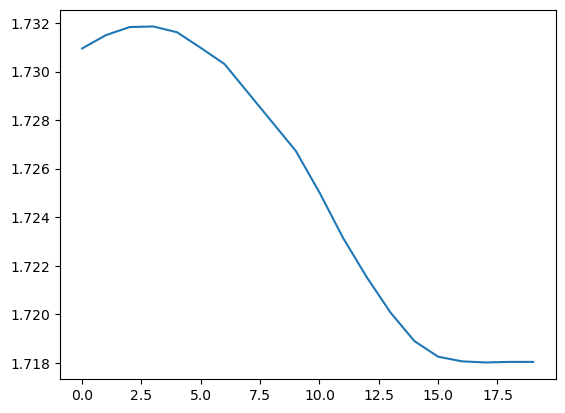

In [93]:
plt.plot(end_points)

In [39]:
saved_global_emakin3=saved_global_emakin
saved_global_kin3=saved_global_kin

In [41]:
saved_OC3=0.9869051268680458

In [65]:
saved_global_emakin4=saved_global_emakin
saved_global_kin4=saved_global_kin

In [63]:
saved_OC4=0.30949495055574533

In [47]:
def forward_moving_average(arr, window_size):
    """
    Smooths a 1D NumPy array using a forward-looking moving average.
    
    Args:
        arr: Input 1D NumPy array
        window_size: Size of the forward-looking window
    
    Returns:
        Smoothed NumPy array of the same length
    """
    n = len(arr)
    smoothed = np.zeros(n)
    
    for i in range(n):
        # Take the mean of the current and future elements within the window
        end_idx = min(i + window_size, n)
        smoothed[i] = np.mean(arr[i:end_idx])
    
    return smoothed

# Example usage
arr = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
window_size = 1500
smoothed_arr = forward_moving_average(np.stack(saved_product1), window_size)
print(smoothed_arr)

[-7.33367597e-06 -1.39510630e-05 -1.99794777e-05 ...  8.88864994e-02
  6.82752848e-01  1.72867680e+00]


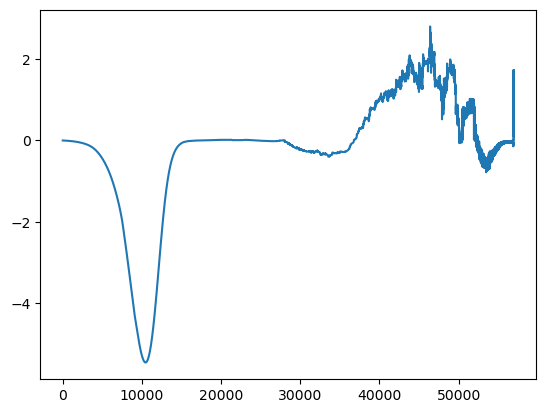

In [49]:
plt.plot(smoothed_arr)

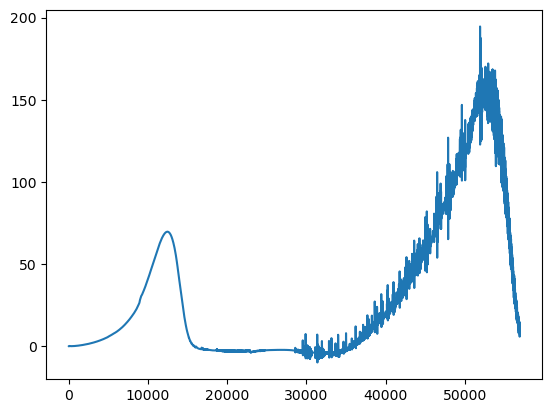

In [51]:
plt.plot(saved_product2)